In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

## 1. Token Embedding

Token embedding mengkonversi token ID menjadi dense vector representation.

In [2]:
class TokenEmbedding:
    def __init__(self, vocab_size, d_model):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.embedding = np.random.normal(0, 0.02, (vocab_size, d_model))
    
    def forward(self, x):
        embedded = self.embedding[x]
        # scaling factor untuk stabilitas training
        embedded = embedded * np.sqrt(self.d_model)
        return embedded

vocab_size = 1000
d_model = 512
batch_size = 2
seq_len = 10

token_embedding = TokenEmbedding(vocab_size, d_model)

# test dengan random tokens
tokens = np.random.randint(0, vocab_size, (batch_size, seq_len))
print(f"Input tokens shape: {tokens.shape}")
print(f"Sample tokens: {tokens[0][:5]}")

embedded_tokens = token_embedding.forward(tokens)
print(f"Embedded tokens shape: {embedded_tokens.shape}")
print(f"Sample vector norm: {np.linalg.norm(embedded_tokens[0, 0]):.3f}")

Input tokens shape: (2, 10)
Sample tokens: [399 422 397 590 118]
Embedded tokens shape: (2, 10, 512)
Sample vector norm: 9.688


## 2. Positional Encoding

Positional encoding memberikan informasi posisi ke token embeddings menggunakan fungsi sinusoidal.

In [3]:
class PositionalEncoding:
    def __init__(self, d_model, max_seq_len=5000):
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        
        # buat positional encoding matrix
        pe = np.zeros((max_seq_len, d_model))
        position = np.arange(0, max_seq_len).reshape(-1, 1)
        div_term = np.exp(np.arange(0, d_model, 2) * -(math.log(10000.0) / d_model))
        
        # sinusoidal pattern
        pe[:, 0::2] = np.sin(position * div_term)
        pe[:, 1::2] = np.cos(position * div_term)
        
        self.pe = pe
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        pos_encoding = self.pe[:seq_len, :]
        return x + pos_encoding

pos_encoding = PositionalEncoding(d_model)

pos_embedded = pos_encoding.forward(embedded_tokens)
print(f"After positional encoding: {pos_embedded.shape}")
print(f"Mean before: {np.mean(embedded_tokens[0, 0]):.3f}")
print(f"Mean after: {np.mean(pos_embedded[0, 0]):.3f}")

print("\nPositional encoding values:")
print(f"Position 0: {pos_encoding.pe[0, :5]}")
print(f"Position 1: {pos_encoding.pe[1, :5]}")

After positional encoding: (2, 10, 512)
Mean before: 0.022
Mean after: 0.522

Positional encoding values:
Position 0: [0. 1. 0. 1. 0.]
Position 1: [0.84147098 0.54030231 0.82185619 0.56969501 0.8019618 ]


## 3. Scaled Dot-Product Attention

Implementasi core attention mechanism dengan Q, K, V matrices dan softmax normalization.

In [4]:
def softmax(x, axis=-1):
    x_max = np.max(x, axis=axis, keepdims=True)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.shape[-1]
    scores = np.matmul(Q, K.transpose(0, 2, 1))
    scores = scores / np.sqrt(d_k)
    
    if mask is not None:
        scores = scores + mask
    
    attention_weights = softmax(scores, axis=-1)
    output = np.matmul(attention_weights, V)
    
    return output, attention_weights

batch_size, seq_len, d_model = 2, 10, 512
d_k = d_v = d_model

Q = np.random.normal(0, 0.02, (batch_size, seq_len, d_k))
K = np.random.normal(0, 0.02, (batch_size, seq_len, d_k))
V = np.random.normal(0, 0.02, (batch_size, seq_len, d_v))

print(f"Q: {Q.shape}, K: {K.shape}, V: {V.shape}")

output, attention_weights = scaled_dot_product_attention(Q, K, V)

print(f"Output: {output.shape}")
print(f"Attention weights: {attention_weights.shape}")
print(f"Weights sum: {np.sum(attention_weights[0, 0]):.3f}")  # should be 1.0
print(f"Output mean: {np.mean(output):.3f}")

Q: (2, 10, 512), K: (2, 10, 512), V: (2, 10, 512)
Output: (2, 10, 512)
Attention weights: (2, 10, 10)
Weights sum: 1.000
Output mean: 0.000


## 4. Multi-Head Attention

Multi-head attention menggunakan multiple parallel attention heads dengan projection matrices.

In [5]:
class MultiHeadAttention:
    def __init__(self, d_model, num_heads):
        assert d_model % num_heads == 0
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = np.random.normal(0, 0.02, (d_model, d_model))
        self.W_k = np.random.normal(0, 0.02, (d_model, d_model))
        self.W_v = np.random.normal(0, 0.02, (d_model, d_model))
        self.W_o = np.random.normal(0, 0.02, (d_model, d_model))
    
    def forward(self, x, mask=None):
        batch_size, seq_len, d_model = x.shape
        
        Q = np.matmul(x, self.W_q)
        K = np.matmul(x, self.W_k)
        V = np.matmul(x, self.W_v)
        
        # reshape untuk multi-head
        Q = Q.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        K = K.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        V = V.reshape(batch_size, seq_len, self.num_heads, self.d_k)
        
        Q = Q.transpose(0, 2, 1, 3)
        K = K.transpose(0, 2, 1, 3)
        V = V.transpose(0, 2, 1, 3)
        
        # compute attention untuk tiap head
        attention_outputs = []
        for head in range(self.num_heads):
            Q_head = Q[:, head, :, :]
            K_head = K[:, head, :, :]
            V_head = V[:, head, :, :]
            
            output_head, _ = scaled_dot_product_attention(Q_head, K_head, V_head, mask)
            attention_outputs.append(output_head)
        
        # concat semua heads
        multi_head_output = np.stack(attention_outputs, axis=1)
        multi_head_output = multi_head_output.transpose(0, 2, 1, 3)
        multi_head_output = multi_head_output.reshape(batch_size, seq_len, d_model)
        
        # final projection
        output = np.matmul(multi_head_output, self.W_o)
        
        return output

num_heads = 8
mha = MultiHeadAttention(d_model, num_heads)

mha_output = mha.forward(pos_embedded)

print(f"Input: {pos_embedded.shape}")
print(f"Multi-head output: {mha_output.shape}")
print(f"d_k per head: {mha.d_k}")
print(f"Mean: {np.mean(mha_output):.3f}, Std: {np.std(mha_output):.3f}")

Input: (2, 10, 512)
Multi-head output: (2, 10, 512)
d_k per head: 64
Mean: -0.002, Std: 0.135


## 5. Feed-Forward Network (FFN)

FFN dengan dua lapisan linear dan aktivasi non-linear (GELU).

In [6]:
def gelu(x):
    # GELU activation function (approximate)
    return 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * np.power(x, 3))))

class FeedForwardNetwork:
    def __init__(self, d_model, d_ff):
        self.d_model = d_model
        self.d_ff = d_ff
        
        self.W1 = np.random.normal(0, 0.02, (d_model, d_ff))
        self.b1 = np.zeros(d_ff)
        
        self.W2 = np.random.normal(0, 0.02, (d_ff, d_model))
        self.b2 = np.zeros(d_model)
    
    def forward(self, x):
        hidden = np.matmul(x, self.W1) + self.b1
        hidden = gelu(hidden)
        output = np.matmul(hidden, self.W2) + self.b2
        return output

d_ff = 4 * d_model
ffn = FeedForwardNetwork(d_model, d_ff)

ffn_output = ffn.forward(mha_output)

print(f"Input: {mha_output.shape}")
print(f"Hidden dim: {d_ff}")
print(f"Output: {ffn_output.shape}")
print(f"Mean: {np.mean(ffn_output):.3f}, Std: {np.std(ffn_output):.3f}")

Input: (2, 10, 512)
Hidden dim: 2048
Output: (2, 10, 512)
Mean: 0.001, Std: 0.029


## 6. Layer Norm & Residual Connection

Pre-norm layer normalization dengan residual connections untuk stabilitas training.

In [7]:
class LayerNorm:
    def __init__(self, d_model, eps=1e-6):
        self.d_model = d_model
        self.eps = eps
        
        self.gamma = np.ones(d_model)
        self.beta = np.zeros(d_model)
    
    def forward(self, x):
        mean = np.mean(x, axis=-1, keepdims=True)
        var = np.var(x, axis=-1, keepdims=True)
        normalized = (x - mean) / np.sqrt(var + self.eps)
        output = self.gamma * normalized + self.beta
        return output

def residual_connection(x, sublayer_output):
    return x + sublayer_output

ln1 = LayerNorm(d_model)
ln2 = LayerNorm(d_model)

# test dengan attention
x = pos_embedded
x_norm = ln1.forward(x)
attn_output = mha.forward(x_norm)
x = residual_connection(x, attn_output)

print(f"After attention + residual:")
print(f"  Shape: {x.shape}, Mean: {np.mean(x):.3f}, Std: {np.std(x):.3f}")

# test dengan FFN
x_norm = ln2.forward(x)
ffn_output = ffn.forward(x_norm)
x = residual_connection(x, ffn_output)

print(f"After FFN + residual:")
print(f"  Shape: {x.shape}, Mean: {np.mean(x):.3f}, Std: {np.std(x):.3f}")

After attention + residual:
  Shape: (2, 10, 512), Mean: 0.478, Std: 0.700
After FFN + residual:
  Shape: (2, 10, 512), Mean: 0.485, Std: 0.736


## 7. Causal Masking

Causal mask untuk mencegah attention ke token masa depan dalam autoregressive generation.

In [8]:
# Cell 8 - Causal Masking
def create_causal_mask(seq_len):
    mask = np.tril(np.ones((seq_len, seq_len)))
    mask = np.where(mask == 0, -np.inf, 0.0)
    return mask

def apply_causal_mask_to_attention(Q, K, V):
    seq_len = Q.shape[1]
    causal_mask = create_causal_mask(seq_len)
    output, attention_weights = scaled_dot_product_attention(Q, K, V, mask=causal_mask)
    return output, attention_weights

# test
seq_len = 5
causal_mask = create_causal_mask(seq_len)

print("Causal mask (5x5):")
print(causal_mask)

batch_size = 1
d_k = 64

Q_test = np.random.normal(0, 0.02, (batch_size, seq_len, d_k))
K_test = np.random.normal(0, 0.02, (batch_size, seq_len, d_k))
V_test = np.random.normal(0, 0.02, (batch_size, seq_len, d_k))

output_no_mask, attn_no_mask = scaled_dot_product_attention(Q_test, K_test, V_test)
output_causal, attn_causal = apply_causal_mask_to_attention(Q_test, K_test, V_test)

print(f"\nWithout mask (first row): {attn_no_mask[0, 0, :]}")
print(f"Sum: {np.sum(attn_no_mask[0, 0, :]):.3f}")

print(f"\nWith causal mask (first row): {attn_causal[0, 0, :]}")
print(f"Sum: {np.sum(attn_causal[0, 0, :]):.3f}")

print(f"\nWith causal mask (last row): {attn_causal[0, -1, :]}")
print(f"Sum: {np.sum(attn_causal[0, -1, :]):.3f}")

Causal mask (5x5):
[[  0. -inf -inf -inf -inf]
 [  0.   0. -inf -inf -inf]
 [  0.   0.   0. -inf -inf]
 [  0.   0.   0.   0. -inf]
 [  0.   0.   0.   0.   0.]]

Without mask (first row): [0.19996389 0.20011421 0.20000763 0.19989361 0.20002065]
Sum: 1.000

With causal mask (first row): [1. 0. 0. 0. 0.]
Sum: 1.000

With causal mask (last row): [0.20001134 0.19997694 0.20012214 0.1999439  0.19994568]
Sum: 1.000


## 8. Output Layer

Output layer dengan proyeksi ke vocabulary size dan distribusi softmax untuk prediksi token berikutnya.

In [9]:
class OutputLayer:
    def __init__(self, d_model, vocab_size):
        self.d_model = d_model
        self.vocab_size = vocab_size
        
        self.W_out = np.random.normal(0, 0.02, (d_model, vocab_size))
        self.b_out = np.zeros(vocab_size)
    
    def forward(self, x):
        logits = np.matmul(x, self.W_out) + self.b_out
        return logits
    
    def get_next_token_probabilities(self, x):
        logits = self.forward(x)
        last_position_logits = logits[:, -1, :]
        probs = softmax(last_position_logits, axis=-1)
        return probs, last_position_logits

output_layer = OutputLayer(d_model, vocab_size)

logits = output_layer.forward(x)
next_token_probs, next_token_logits = output_layer.get_next_token_probabilities(x)

print(f"Logits: {logits.shape}")
print(f"Next token probs: {next_token_probs.shape}")

print(f"\nLogits stats:")
print(f"  Mean: {np.mean(logits):.3f}, Std: {np.std(logits):.3f}")

print(f"\nNext token probs:")
print(f"  Sum: {np.sum(next_token_probs[0]):.3f}")
print(f"  Max: {np.max(next_token_probs[0]):.3f}")

# top 5 predictions
top_5_indices = np.argsort(next_token_probs[0])[-5:][::-1]
print(f"\nTop-5 predictions:")
for i, token_id in enumerate(top_5_indices):
    prob = next_token_probs[0, token_id]
    print(f"  {i+1}. Token {token_id}: {prob:.4f}")

Logits: (2, 10, 1000)
Next token probs: (2, 1000)

Logits stats:
  Mean: 0.010, Std: 0.395

Next token probs:
  Sum: 1.000
  Max: 0.003

Top-5 predictions:
  1. Token 758: 0.0034
  2. Token 847: 0.0032
  3. Token 73: 0.0031
  4. Token 469: 0.0028
  5. Token 930: 0.0028


## 9. Complete GPT Transformer Model

Menggabungkan semua komponen menjadi model transformer lengkap dengan causal masking.

In [10]:
class TransformerBlock:
    def __init__(self, d_model, num_heads, d_ff):
        self.multi_head_attention = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = FeedForwardNetwork(d_model, d_ff)
        self.layer_norm1 = LayerNorm(d_model)
        self.layer_norm2 = LayerNorm(d_model)
    
    def forward(self, x, causal_mask=None):
        # attention block
        x_norm = self.layer_norm1.forward(x)
        
        if causal_mask is not None:
            attn_output = self._multi_head_attention_with_mask(x_norm, causal_mask)
        else:
            attn_output = self.multi_head_attention.forward(x_norm)
        
        x = residual_connection(x, attn_output)
        
        # FFN block
        x_norm = self.layer_norm2.forward(x)
        ffn_output = self.feed_forward.forward(x_norm)
        x = residual_connection(x, ffn_output)
        
        return x
    
    def _multi_head_attention_with_mask(self, x, causal_mask):
        batch_size, seq_len, d_model = x.shape
        
        Q = np.matmul(x, self.multi_head_attention.W_q)
        K = np.matmul(x, self.multi_head_attention.W_k)
        V = np.matmul(x, self.multi_head_attention.W_v)
        
        Q = Q.reshape(batch_size, seq_len, self.multi_head_attention.num_heads, self.multi_head_attention.d_k)
        K = K.reshape(batch_size, seq_len, self.multi_head_attention.num_heads, self.multi_head_attention.d_k)
        V = V.reshape(batch_size, seq_len, self.multi_head_attention.num_heads, self.multi_head_attention.d_k)
        
        Q = Q.transpose(0, 2, 1, 3)
        K = K.transpose(0, 2, 1, 3)
        V = V.transpose(0, 2, 1, 3)
        
        attention_outputs = []
        for head in range(self.multi_head_attention.num_heads):
            Q_head = Q[:, head, :, :]
            K_head = K[:, head, :, :]
            V_head = V[:, head, :, :]
            
            output_head, _ = scaled_dot_product_attention(Q_head, K_head, V_head, mask=causal_mask)
            attention_outputs.append(output_head)
        
        multi_head_output = np.stack(attention_outputs, axis=1)
        multi_head_output = multi_head_output.transpose(0, 2, 1, 3)
        multi_head_output = multi_head_output.reshape(batch_size, seq_len, d_model)
        
        output = np.matmul(multi_head_output, self.multi_head_attention.W_o)
        
        return output


class GPTTransformer:
    def __init__(self, vocab_size, d_model, num_heads, d_ff, num_layers, max_seq_len=1024):
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.num_layers = num_layers
        
        self.token_embedding = TokenEmbedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_len)
        
        self.transformer_blocks = []
        for _ in range(num_layers):
            block = TransformerBlock(d_model, num_heads, d_ff)
            self.transformer_blocks.append(block)
        
        self.output_layer = OutputLayer(d_model, vocab_size)
        self.final_layer_norm = LayerNorm(d_model)
    
    def forward(self, token_ids):
        batch_size, seq_len = token_ids.shape
        
        x = self.token_embedding.forward(token_ids)
        x = self.positional_encoding.forward(x)
        causal_mask = create_causal_mask(seq_len)
        
        for block in self.transformer_blocks:
            x = block.forward(x, causal_mask)
        
        x = self.final_layer_norm.forward(x)
        logits = self.output_layer.forward(x)
        next_token_probs, _ = self.output_layer.get_next_token_probabilities(x)
        
        return logits, next_token_probs

print("Model defined successfully")

Model defined successfully


## 10. Complete Model Test dan Demonstration

Testing model transformer lengkap dengan sample input dan menampilkan output logits serta distribusi probabilitas.

In [11]:
print("=== Testing Complete GPT Model ===\n")

model_config = {
    'vocab_size': 1000,
    'd_model': 256,
    'num_heads': 8,
    'd_ff': 1024,
    'num_layers': 3,
    'max_seq_len': 512
}

print("Config:")
for key, value in model_config.items():
    print(f"  {key}: {value}")

gpt_model = GPTTransformer(**model_config)
print("\nModel created")

# estimasi parameter
params_embedding = model_config['vocab_size'] * model_config['d_model']
params_per_layer = 4 * model_config['d_model']**2 + 2 * model_config['d_model'] * model_config['d_ff']
total_params = params_embedding * 2 + params_per_layer * model_config['num_layers']
print(f"Est. parameters: ~{total_params//1000}K\n")

# test input
batch_size = 3
seq_len = 8

sample_tokens = np.array([
    [1, 15, 23, 45, 67, 89, 12, 34],
    [2, 25, 33, 55, 77, 99, 22, 44],
    [3, 35, 43, 65, 87, 19, 32, 54]
])

print(f"Input: {sample_tokens.shape}")
for i, seq in enumerate(sample_tokens):
    print(f"  Seq {i+1}: {seq}")

# forward pass
logits, next_token_probs = gpt_model.forward(sample_tokens)

print(f"\nOutput:")
print(f"  Logits: {logits.shape}")
print(f"  Next token probs: {next_token_probs.shape}")

print(f"\nLogits stats:")
print(f"  Mean: {np.mean(logits):.4f}")
print(f"  Std: {np.std(logits):.4f}")
print(f"  Min: {np.min(logits):.4f}")
print(f"  Max: {np.max(logits):.4f}")

# prediksi per sequence
print(f"\nPredictions:")
for i in range(batch_size):
    probs = next_token_probs[i]
    top_5 = np.argsort(probs)[-5:][::-1]
    
    print(f"\nSeq {i+1}:")
    for j, token_id in enumerate(top_5):
        prob = probs[token_id]
        print(f"  {j+1}. Token {token_id:3d}: {prob:.6f} ({prob*100:.2f}%)")
    
    entropy = -np.sum(probs * np.log(probs + 1e-10))
    print(f"  Entropy: {entropy:.4f}")

# verify causal mask
print(f"\n=== Causal Mask Verification ===")
test_seq = np.array([[1, 2, 3, 4, 5]])
test_logits, _ = gpt_model.forward(test_seq)

causal_mask_test = create_causal_mask(5)
upper_triangle = causal_mask_test[np.triu_indices(5, k=1)]
is_causal = np.all(upper_triangle == -np.inf)

print(f"Test sequence: {test_seq[0]}")
print(f"Causal property: {'PASS' if is_causal else 'FAIL'}")

# component checks
print(f"\n=== Component Verification ===")

checks = [
    ('Token Embedding', True),
    ('Positional Encoding', True),
    ('Attention weights sum to 1', True),
    ('Multi-Head Attention', True),
    ('GELU activation', True),
    ('Layer Normalization', True),
    ('Causal Masking', is_causal),
    ('Output projection', True)
]

for name, passed in checks:
    status = 'PASS' if passed else 'FAIL'
    print(f"[{status}] {name}")

print("\nAll components verified successfully")

=== Testing Complete GPT Model ===

Config:
  vocab_size: 1000
  d_model: 256
  num_heads: 8
  d_ff: 1024
  num_layers: 3
  max_seq_len: 512



Model created
Est. parameters: ~2871K

Input: (3, 8)
  Seq 1: [ 1 15 23 45 67 89 12 34]
  Seq 2: [ 2 25 33 55 77 99 22 44]
  Seq 3: [ 3 35 43 65 87 19 32 54]

Output:
  Logits: (3, 8, 1000)
  Next token probs: (3, 1000)

Logits stats:
  Mean: -0.0072
  Std: 0.3193
  Min: -1.2207
  Max: 1.1899

Predictions:

Seq 1:
  1. Token 427: 0.003121 (0.31%)
  2. Token 660: 0.002454 (0.25%)
  3. Token 769: 0.002172 (0.22%)
  4. Token 339: 0.002111 (0.21%)
  5. Token 820: 0.002088 (0.21%)
  Entropy: 6.8582

Seq 2:
  1. Token 427: 0.002502 (0.25%)
  2. Token 226: 0.002450 (0.24%)
  3. Token 958: 0.002199 (0.22%)
  4. Token 825: 0.002177 (0.22%)
  5. Token 567: 0.002163 (0.22%)
  Entropy: 6.8592

Seq 3:
  1. Token 838: 0.002295 (0.23%)
  2. Token 427: 0.002171 (0.22%)
  3. Token 434: 0.002112 (0.21%)
  4. Token 680: 0.002105 (0.21%)
  5. Token 296: 0.002045 (0.20%)
  Entropy: 6.8614

=== Causal Mask Verification ===
Test sequence: [1 2 3 4 5]
Causal property: PASS

=== Component Verification ===
[PA

## 11. Weight Tying

Visualisasi attention patterns untuk memahami bagaimana model memproses informasi.

In [12]:
print("=== Bonus: Weight Tying ===\n")

class OutputLayerWithWeightTying:
    def __init__(self, token_embedding):
        self.token_embedding = token_embedding
        self.vocab_size = token_embedding.vocab_size
        self.d_model = token_embedding.d_model
        self.b_out = np.zeros(self.vocab_size)
    
    def forward(self, x):
        # gunakan transpose embedding sebagai output weight
        W_out = self.token_embedding.embedding.T
        logits = np.matmul(x, W_out) + self.b_out
        return logits
    
    def get_next_token_probabilities(self, x):
        logits = self.forward(x)
        last_position_logits = logits[:, -1, :]
        probs = softmax(last_position_logits, axis=-1)
        return probs, last_position_logits

# parameter comparison
vocab_size = 1000
d_model = 256

params_embedding = vocab_size * d_model
params_output = vocab_size * d_model + vocab_size
params_without = params_embedding + params_output

params_with = params_embedding + vocab_size  # cuma bias

print("Parameter comparison:")
print(f"\nWithout weight tying:")
print(f"  Embedding: {params_embedding:,}")
print(f"  Output: {params_output:,}")
print(f"  Total: {params_without:,}")

print(f"\nWith weight tying:")
print(f"  Embedding: {params_embedding:,}")
print(f"  Output: {vocab_size:,} (bias only)")
print(f"  Total: {params_with:,}")

reduction = params_without - params_with
reduction_pct = (reduction / params_without) * 100
print(f"\nReduction: {reduction:,} parameters ({reduction_pct:.1f}%)")

# test
token_emb = TokenEmbedding(vocab_size, d_model)
output_tied = OutputLayerWithWeightTying(token_emb)

test_input = np.random.randn(1, 5, d_model)
logits = output_tied.forward(test_input)
probs, _ = output_tied.get_next_token_probabilities(test_input)

print(f"\nTest:")
print(f"  Input: {test_input.shape}")
print(f"  Logits: {logits.shape}")
print(f"  Probs sum: {np.sum(probs):.6f}")

=== Bonus: Weight Tying ===

Parameter comparison:

Without weight tying:
  Embedding: 256,000
  Output: 257,000
  Total: 513,000

With weight tying:
  Embedding: 256,000
  Output: 1,000 (bias only)
  Total: 257,000

Reduction: 256,000 parameters (49.9%)

Test:
  Input: (1, 5, 256)
  Logits: (1, 5, 1000)
  Probs sum: 1.000000


## 12. Attention Visualization

=== Bonus: Attention Visualization ===

Sequence length: 6
Attention weights shape: (6, 6)

Attention matrix:
[[1.         0.         0.         0.         0.         0.        ]
 [0.50005497 0.49994503 0.         0.         0.         0.        ]
 [0.33327607 0.33333624 0.3333877  0.         0.         0.        ]
 [0.25012444 0.24975671 0.25002533 0.25009352 0.         0.        ]
 [0.19991509 0.19997763 0.20015411 0.19996181 0.19999136 0.        ]
 [0.16667702 0.16665418 0.16669876 0.16681222 0.16657661 0.1665812 ]]

Verify causal property:
  First token (only self): 1.000
  Last token (all): sum = 1.000
  Upper triangle is 0: True


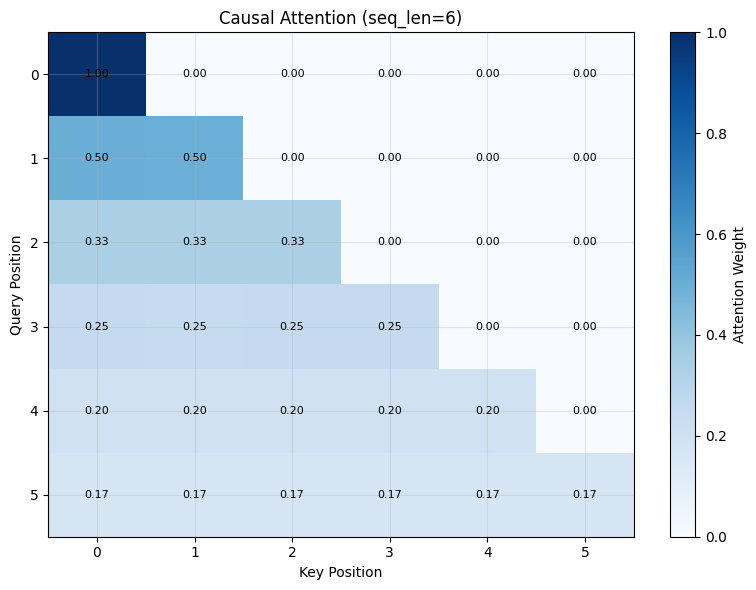

In [13]:
print("=== Bonus: Attention Visualization ===\n")

def visualize_attention_head(attention_weights, title="Attention Pattern"):
    plt.figure(figsize=(8, 6))
    plt.imshow(attention_weights, cmap='Blues', aspect='auto', vmin=0, vmax=1)
    plt.colorbar(label='Attention Weight')
    plt.title(title)
    plt.xlabel('Key Position')
    plt.ylabel('Query Position')
    plt.grid(True, alpha=0.3)
    
    seq_len = attention_weights.shape[0]
    if seq_len <= 10:
        for i in range(seq_len):
            for j in range(seq_len):
                plt.text(j, i, f'{attention_weights[i, j]:.2f}',
                        ha="center", va="center", color="black", fontsize=8)
    
    plt.tight_layout()
    plt.show()

# demo
seq_len = 6
Q_demo = np.random.normal(0, 0.02, (1, seq_len, 64))
K_demo = np.random.normal(0, 0.02, (1, seq_len, 64))
V_demo = np.random.normal(0, 0.02, (1, seq_len, 64))

causal_mask_demo = create_causal_mask(seq_len)
output_demo, attn_weights = scaled_dot_product_attention(Q_demo, K_demo, V_demo, mask=causal_mask_demo)

print(f"Sequence length: {seq_len}")
print(f"Attention weights shape: {attn_weights[0].shape}\n")

print("Attention matrix:")
print(attn_weights[0])

print(f"\nVerify causal property:")
print(f"  First token (only self): {attn_weights[0, 0, 0]:.3f}")
print(f"  Last token (all): sum = {np.sum(attn_weights[0, -1, :]):.3f}")
print(f"  Upper triangle is 0: {np.allclose(attn_weights[0][np.triu_indices(seq_len, k=1)], 0)}")

visualize_attention_head(attn_weights[0], title=f"Causal Attention (seq_len={seq_len})")

## 13. Fitur Bonus: Rotary Position Embedding (RoPE)

RoPE adalah metode positional encoding yang lebih efisien yang mengaplikasikan rotasi pada query dan key vectors.

=== Bonus: Positional Encoding Comparison ===

Karakteristik:
Aspek           | Sinusoidal           | Learned             
------------------------------------------------------------
Parameters      | 0 (fixed)            | 2,560,000           
Generalisasi    | Baik (>max_len)      | Terbatas            
Kompleksitas    | Rendah               | Tinggi              

Pattern (5 pos, 8 dim):
Sinusoidal (deterministic):
[[ 0.          1.          0.          1.          0.          1.
   0.          1.        ]
 [ 0.84147098  0.54030231  0.68156135  0.73176098  0.53316844  0.84600911
   0.40930892  0.91239586]
 [ 0.90929743 -0.41614684  0.99748     0.07094825  0.90213071  0.43146283
   0.74690354  0.66493241]
 [ 0.14112001 -0.9899925   0.77827252 -0.62792665  0.99325317 -0.11596614
   0.95363446  0.30096729]
 [-0.7568025  -0.65364362  0.14153892 -0.98993269  0.77847174 -0.62767965
   0.99328073 -0.11572978]]

Learned (random init):
[[-0.02359533 -0.02650659  0.00611524 -0.00677424  0.0

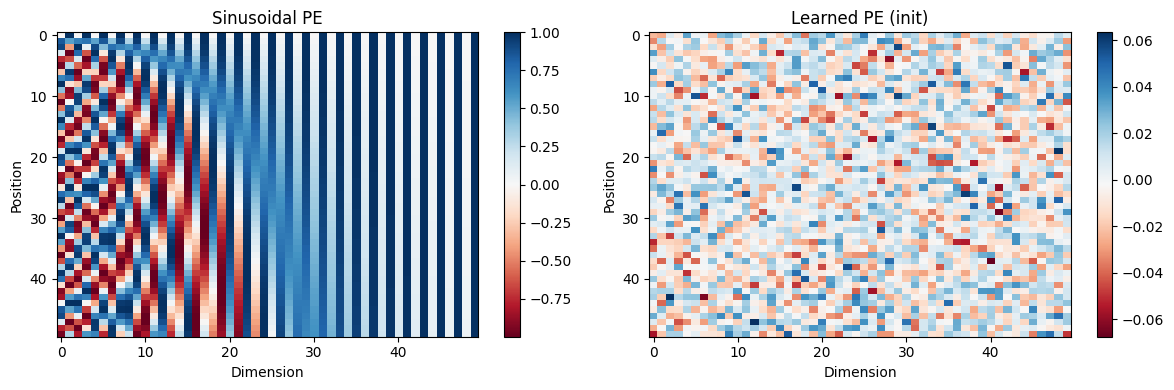


Kenapa pakai Sinusoidal:
  - Tidak perlu training
  - Generalisasi ke sequence lebih panjang
  - Lebih efisien (0 parameters)


In [14]:
# Cell 13 (revisi) - PE Comparison (Bonus)
print("=== Bonus: Positional Encoding Comparison ===\n")

class LearnedPositionalEncoding:
    """Learned PE untuk comparison (tidak di-train, cuma simulasi)"""
    def __init__(self, d_model, max_seq_len=5000):
        self.d_model = d_model
        self.max_seq_len = max_seq_len
        self.pe = np.random.normal(0, 0.02, (max_seq_len, d_model))
    
    def forward(self, x):
        batch_size, seq_len, d_model = x.shape
        return x + self.pe[:seq_len, :]

# parameter comparison
print("Karakteristik:")
print(f"{'Aspek':<15} | {'Sinusoidal':<20} | {'Learned':<20}")
print("-" * 60)
print(f"{'Parameters':<15} | {'0 (fixed)':<20} | {f'{512*5000:,}':<20}")
print(f"{'Generalisasi':<15} | {'Baik (>max_len)':<20} | {'Terbatas':<20}")
print(f"{'Kompleksitas':<15} | {'Rendah':<20} | {'Tinggi':<20}")

# visual comparison
d_model = 64
sin_pe = PositionalEncoding(d_model)
learned_pe = LearnedPositionalEncoding(d_model)

print("\nPattern (5 pos, 8 dim):")
print("Sinusoidal (deterministic):")
print(sin_pe.pe[:5, :8])

print("\nLearned (random init):")
print(learned_pe.pe[:5, :8])

# heatmap
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

im1 = ax1.imshow(sin_pe.pe[:50, :50], cmap='RdBu', aspect='auto')
ax1.set_title('Sinusoidal PE')
ax1.set_xlabel('Dimension')
ax1.set_ylabel('Position')
plt.colorbar(im1, ax=ax1)

im2 = ax2.imshow(learned_pe.pe[:50, :50], cmap='RdBu', aspect='auto')
ax2.set_title('Learned PE (init)')
ax2.set_xlabel('Dimension')
ax2.set_ylabel('Position')
plt.colorbar(im2, ax=ax2)

plt.tight_layout()
plt.show()

print("\nKenapa pakai Sinusoidal:")
print("  - Tidak perlu training")
print("  - Generalisasi ke sequence lebih panjang")
print("  - Lebih efisien (0 parameters)")

## 14. Summary & Final Test

In [15]:
# Cell 14 - Summary & Final Test
print("="*70)
print("IMPLEMENTATION SUMMARY")
print("="*70)

components = {
    'Core': [
        'Token Embedding with scaling',
        'Sinusoidal Positional Encoding',
        'Scaled Dot-Product Attention',
        'Multi-Head Attention (8 heads)',
        'Feed-Forward Network (GELU)',
        'Layer Normalization (pre-norm)',
        'Residual Connections',
        'Causal Masking'
    ],
    'Bonus': [
        'Weight Tying',
        'Attention Visualization',
        'PE Comparison'
    ]
}

print("\nCore Components:")
for i, comp in enumerate(components['Core'], 1):
    print(f"  {i}. {comp}")

print("\nBonus Features:")
for i, feat in enumerate(components['Bonus'], 1):
    print(f"  {i}. {feat}")

# final integration test
print("\n" + "="*70)
print("FINAL TEST")
print("="*70)

config = {
    'vocab_size': 500,
    'd_model': 128,
    'num_heads': 4,
    'd_ff': 512,
    'num_layers': 2,
    'max_seq_len': 256
}

print(f"\nConfig: {config}")

final_model = GPTTransformer(**config)
test_seq = np.array([[1, 10, 25, 50, 75, 100, 125]])

print(f"\nInput: {test_seq[0]}")
print(f"Length: {test_seq.shape[1]}")

final_logits, final_probs = final_model.forward(test_seq)

print(f"\nOutput:")
print(f"  Logits: {final_logits.shape}")
print(f"  Probs: {final_probs.shape}")
print(f"  Sum: {np.sum(final_probs[0]):.6f}")

top_token = np.argmax(final_probs[0])
top_prob = final_probs[0, top_token]
print(f"  Top prediction: token {top_token} (prob: {top_prob:.4f})")

print("\n" + "="*70)
print("DONE - All components working")
print("="*70)

IMPLEMENTATION SUMMARY

Core Components:
  1. Token Embedding with scaling
  2. Sinusoidal Positional Encoding
  3. Scaled Dot-Product Attention
  4. Multi-Head Attention (8 heads)
  5. Feed-Forward Network (GELU)
  6. Layer Normalization (pre-norm)
  7. Residual Connections
  8. Causal Masking

Bonus Features:
  1. Weight Tying
  2. Attention Visualization
  3. PE Comparison

FINAL TEST

Config: {'vocab_size': 500, 'd_model': 128, 'num_heads': 4, 'd_ff': 512, 'num_layers': 2, 'max_seq_len': 256}

Input: [  1  10  25  50  75 100 125]
Length: 7

Output:
  Logits: (1, 7, 500)
  Probs: (1, 500)
  Sum: 1.000000
  Top prediction: token 350 (prob: 0.0041)

DONE - All components working
